# Importing and cleaning

In [3]:
import pandas as pd
import graphviz 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as sc
import statistics

from sklearn.model_selection import train_test_split
from sklearn import tree

In [6]:
df = pd.read_csv('AppleStore.csv', sep=',', header=0, index_col=0)

## Cleaning

Dropping the non relevant columns for our analysis. We don't care about the ID, the name of the app, its size, currency (they're all USD), current version, and whatever vpp_lic is (they're all == 1 anyway).

In [7]:
df = df.drop(['id','track_name', 'size_bytes', 'currency', 'ver', 'vpp_lic'], axis = 1)

In [8]:
df.head()

,price,rating_count_tot,rating_count_ver,user_rating,user_rating_ver,cont_rating,prime_genre,sup_devices.num,ipadSc_urls.num,lang.num
1,3.99,21292,26,4.0,4.5,4+,Games,38,5,10
2,0.00,161065,26,4.0,3.5,4+,Productivity,37,5,23
3,0.00,188583,2822,3.5,4.5,4+,Weather,37,5,3
4,0.00,262241,649,4.0,4.5,12+,Shopping,37,5,9
5,0.00,985920,5320,4.5,5.0,4+,Reference,37,5,45


Dropping the categorical variables.

In [4]:
df_nocat = df.drop(['cont_rating', 'prime_genre'], axis=1)

And storing them for later use.

In [5]:
df_cont = df[['cont_rating']]
df_gen = df[['prime_genre']]

Let's take a look at the data.

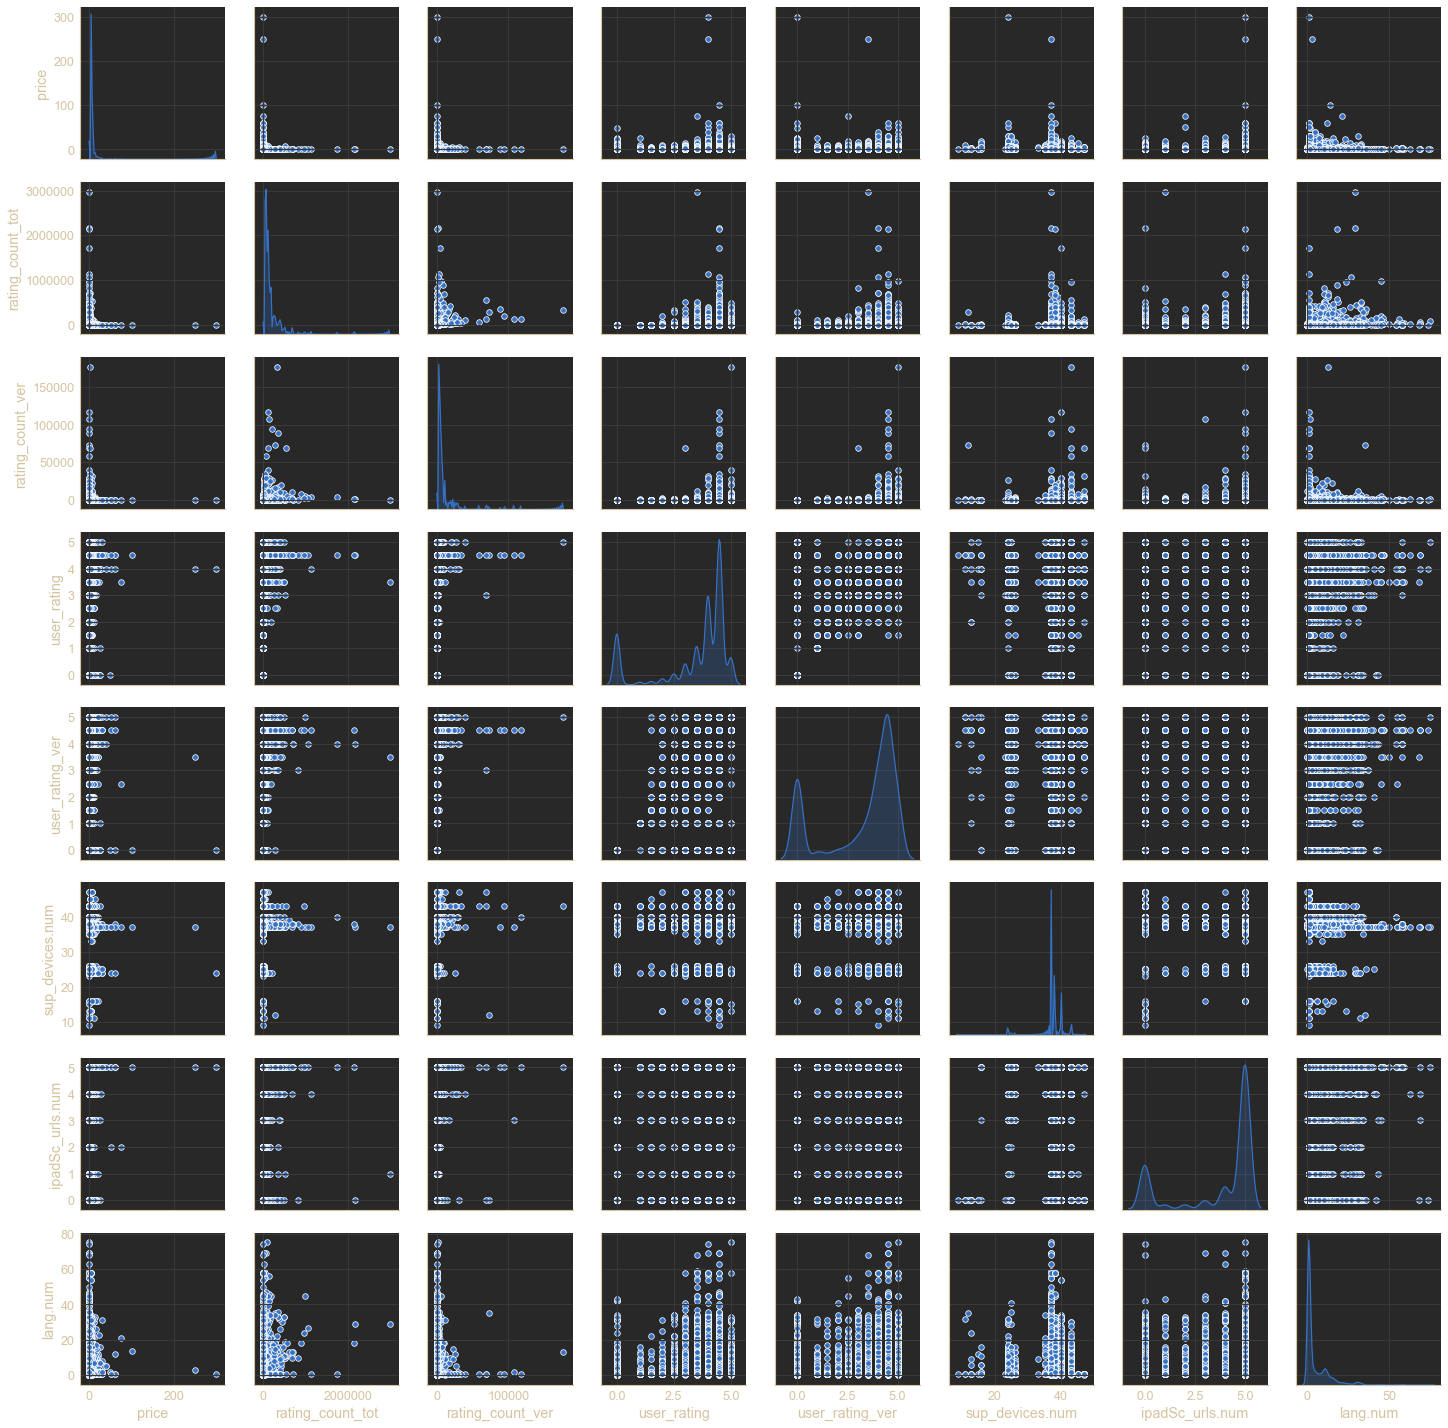

In [6]:
sns.pairplot(df_nocat, diag_kind='kde')

Not really representative or useful at the moment...

However, we can see from some univariate distributions that there are few outliers. We can remove them in order to prevent our following analyses from being somewhat skewed.

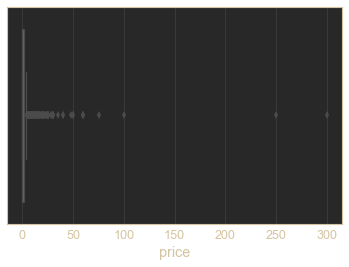

In [7]:
sns.boxplot(df_nocat['price'])

### Removing outliers (Z-score method)

Let's normalize data and transform it in absolute value so that we can identify the outliers (value > 3), that is to say they're above the 3rd standard deviation.

In [8]:
z_score = np.abs(sc.zscore(df_nocat))
# normalizes data, returns absolute value

df_nocat = df_nocat.reset_index(drop=True)
# resets the index of df_nocat, start at 0

rem_row = np.unique(np.where(z_score > 3)[0])
# returns indexes of the rows that have at least
# one z_score > 3

df_nocat_noout = df_nocat.drop(rem_row, axis=0)
# removes rows that contain outliers,
# saves in new dataframe

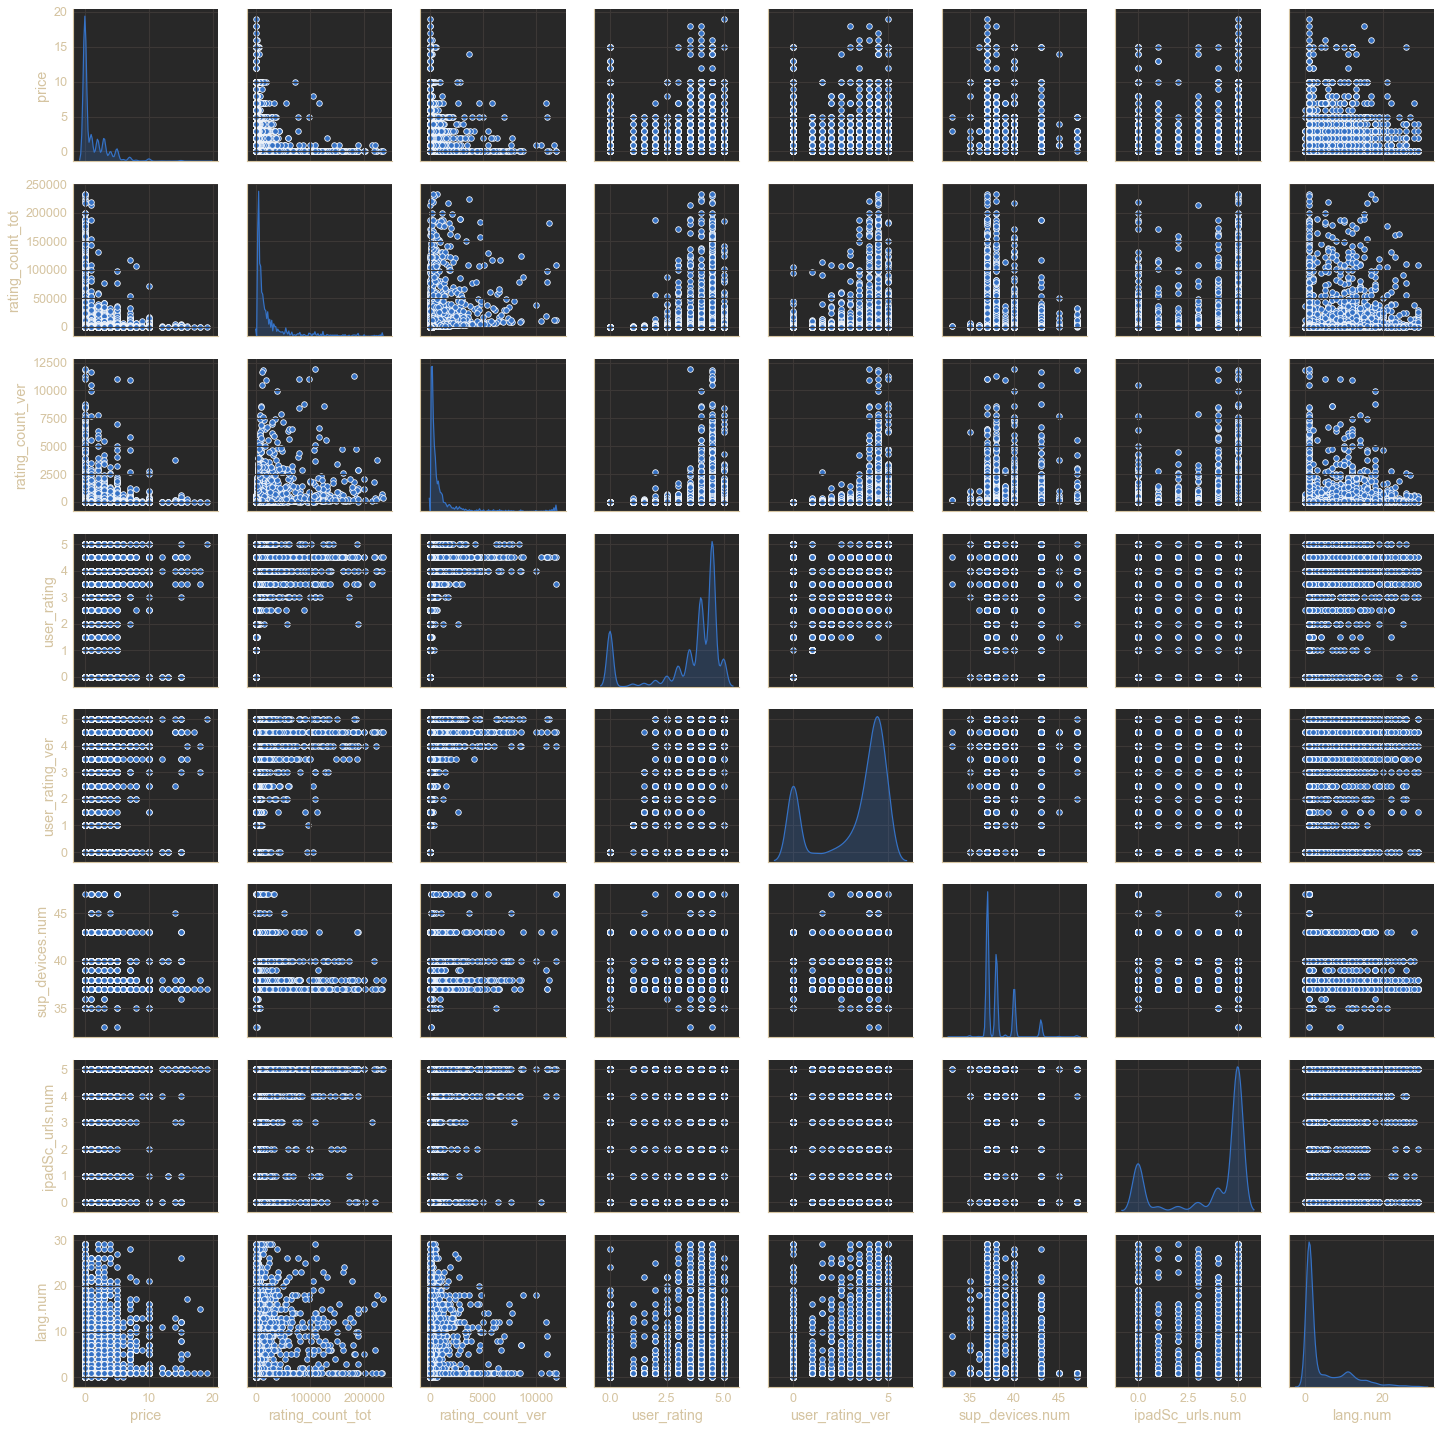

In [9]:
sns.pairplot(df_nocat_noout, diag_kind='kde')

A little better. Now at least univariate distribution of price is something more than a vertical line above the 0 value. Sure, the majority of apps are free, but the previous KDE was unreadable.

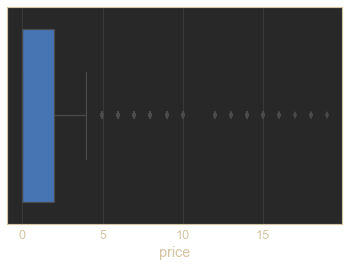

In [10]:
sns.boxplot(df_nocat_noout['price'])

# Starter analysis

## Correlation heatmap

Let's build a correlation heatmap to see if there is any relevant correlation between the variables.

In [11]:
corr = df_nocat_noout.corr()

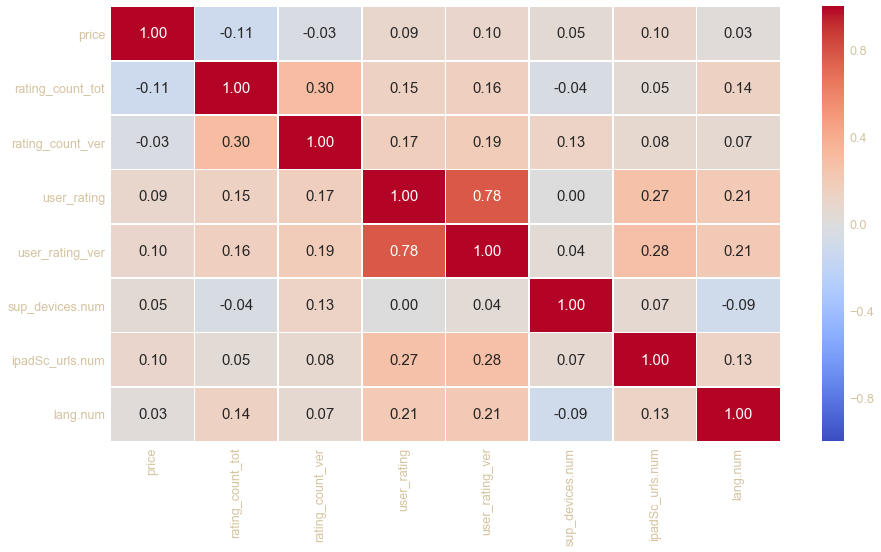

In [12]:
fig, ax = plt.subplots(figsize=(15,8))

hm = sns.heatmap(corr,
                 ax=ax,
                 cmap='coolwarm',
                 vmin=-1.0,
                 vmax=1.0,
                 annot=True,
                 fmt='.2f',
                 annot_kws={'size':15},
                 linewidths=0.5)

There's very low correlations between most attributes, looks like we need go further and use all the variables for our analysis.

Next we'll try to put user rating as "class", drop it from the DF, put back categorical variables, run a decision tree, see results, ????, profit.

## Decision tree

### Setup

We start by adding back the 2 categorical variables that we removed before, of course removing the rows that correspond to outlier data.

In [13]:
df_cont = df_cont.reset_index(drop=True)
df_gen = df_gen.reset_index(drop=True)
# resets the index of content rating and genre attributes, start at 0

df_cont = df_cont.drop(rem_row, axis=0)
df_gen = df_gen.drop(rem_row, axis=0)

# removes rows that contain outliers,
# saves in same dataframe

In [66]:
df_tree = pd.concat([df_nocat_noout, df_cont, df_gen], axis = 1)
#puts back the 2 attribute columns in the dataframe

In [67]:
df_tree['prime_genre'] = df_tree['prime_genre'].str.replace('&','and')
#replacs "&" with "and" because otherwise the decision tree graph goes bananas and produces
#2 billion errors.

We wanna to find out if _user rating_ is somewhat functionally dependent on a combination of other attributes, and to what degree. Let's group ratings arbitrarily, with this criteria:
- Last version rating > 3.5 : __Good__
- Last version rating ≥ 3.0 : __Okish__
- Last version rating < 3.0 : __Bad__

In [68]:
conditions = [
    (df_nocat_noout['user_rating_ver'] > 3.5),
    ((df_nocat_noout['user_rating_ver'] > 2.5) & (df_nocat_noout['user_rating_ver'] <= 3.5)),
    (df_nocat_noout['user_rating_ver'] < 3.0)]
choices = ['Good', 'Okish', 'Bad']

df_tree['Grade'] = np.select(conditions, choices, default=None)

Then we drop the user rating attributes from the DF.

In [69]:
df_tree = df_tree.drop(['user_rating_ver','user_rating'], axis=1)

Let's also drop rating count because otherwise the tree makes no sense.

In [53]:
df_tree = df_tree.drop(['rating_count_tot','rating_count_ver'], axis=1)

Assign the Grade column to a new DF.

In [70]:
df_grade = df_tree[['Grade']]

And drop it again from the original DF.

In [71]:
df_tree = df_tree.drop('Grade', axis=1)

In [72]:
df_tree.head()

,price,rating_count_tot,rating_count_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating,prime_genre
0,3.99,21292,26,38,5,10,4+,Games
1,0.00,161065,26,37,5,23,4+,Productivity
2,0.00,188583,2822,37,5,3,4+,Weather
5,0.99,8253,5516,47,5,1,4+,Games
6,0.00,119487,879,37,0,19,4+,Finance


There is an issue now. Sklearn decision tree does not handle categorical variables (such as _genre_). Only numerical ones. The second problem is that if we convert our categorical variables to numbers, the algorithm will think that they're ordinal, and therefore the higher the number the better, which in this case is obviously not only wrong, but also nonsensical.

We need to transform the categorical variables into __dummy__ ones.

### "Dummyfication" of categorical variables (one hot encoding)

In [90]:
one_hot_data = pd.get_dummies(df_tree, columns=['cont_rating','prime_genre'])

In [91]:
one_hot_data.head()

,price,rating_count_tot,rating_count_ver,sup_devices.num,ipadSc_urls.num,lang.num,cont_rating_12+,cont_rating_17+,cont_rating_4+,cont_rating_9+,...,prime_genre_News,prime_genre_Photo and Video,prime_genre_Productivity,prime_genre_Reference,prime_genre_Shopping,prime_genre_Social Networking,prime_genre_Sports,prime_genre_Travel,prime_genre_Utilities,prime_genre_Weather
0,3.99,21292,26,38,5,10,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0.00,161065,26,37,5,23,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
2,0.00,188583,2822,37,5,3,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
5,0.99,8253,5516,47,5,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,0.00,119487,879,37,0,19,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


In [93]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_data, df_grade)
print("There are {} samples in the training dataset".format(X_train.shape[0]))
print("There are {} samples in the testing dataset".format(X_test.shape[0]))
print("Each sample has {} features".format(X_train.shape[1]))

There are 4854 samples in the training dataset
There are 1619 samples in the testing dataset
Each sample has 32 features


In [94]:
rnd_state = 666
clf = tree.DecisionTreeClassifier(criterion='entropy', random_state = rnd_state)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=666,
            splitter='best')

In [95]:
y_test = np.array(y_test)
y_train = np.array(y_train)
#transforms the dataframes into arrays so we can use them for comparison

In [96]:
y_predicted_train = clf.predict(X_train)
accuracy_train = np.mean(y_train == y_predicted_train)*100
print("The accuracy on training set is {0:.1f}%".format(accuracy_train))

The accuracy on training set is 45.8%


In [97]:
y_predicted_test = clf.predict(X_test)
accuracy_test = np.mean(y_test == y_predicted_test)*100
print("The accuracy on training set is {0:.1f}%".format(accuracy_test))

The accuracy on training set is 46.2%


The accuracy on this method is less than a coinflip, therefore useless. Also, the resulting decision tree is a nightmare. Need to do some further analysis.

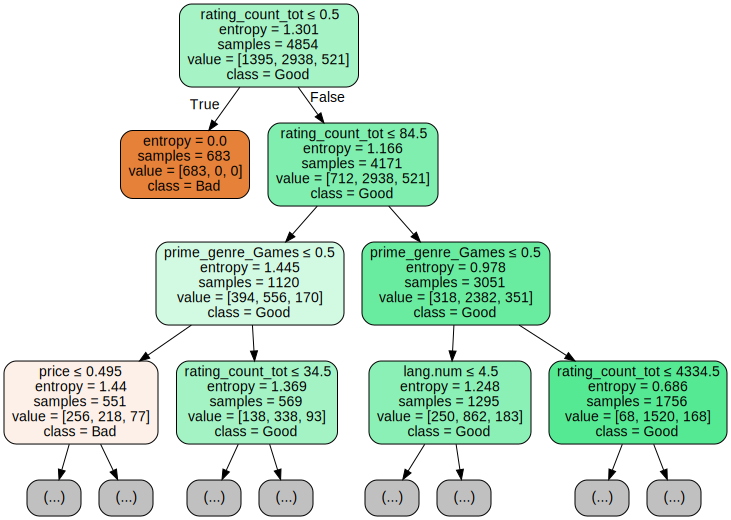

In [89]:
dot_data = tree.export_graphviz(clf, out_file=None,
                                feature_names=list(one_hot_data.keys()),
                                class_names=np.unique(df_grade),
                                filled=True, rounded=True,
                                special_characters=True,
                                max_depth= 3)  
graph = graphviz.Source(dot_data)  
graph

# Exploratory Text Mining

Given that we have a second dataset containing the description of every app, it could be interesting to try and see if we can find any meaningful information from that. For example, what are the most common themes within our dataset.

## Importing the descriptive dataset

Let's start with the simplest (but probably most effective) way to find word frequencies: wordcloud.

In [6]:
from wordcloud import WordCloud, STOPWORDS

In [326]:
df_text = pd.read_csv("appleStore_description.csv", sep=',', header=0)
df_text.head()

,id,track_name,size_bytes,app_desc
0,281656475,PAC-MAN Premium,100788224,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,281796108,Evernote - stay organized,158578688,Let Evernote change the way you organize your ...
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,Download the most popular free weather app pow...
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,The eBay app is the best way to find anything ...
4,282935706,Bible,92774400,On more than 250 million devices around the wo...


In [9]:
desc = df_text[['app_desc']]
#extracting the description column from the dataframe

## Wordclouds

In [10]:
wordcloud = WordCloud().generate(desc.app_desc[0])
#1st try of a simple wordcloud for the 1st app in the df

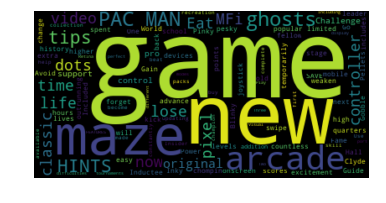

In [11]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

Since the 1st app is PACMAN, it's not surprising that the most frequent word is "game". A good thing to notice is that the library seems to already exclude from its analyses noise words such as adverbs, pronouns, conjunctions etc.

Let's now try to produce a wordcloud for all the dataframe.

In [325]:
text = " ".join(descr for descr in desc.app_desc)
#joins all the descriptions into one single string

In [48]:
wordcloud = WordCloud().generate(text)

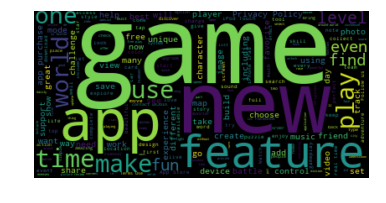

In [49]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

From the new wordcloud it is evident that "game" is the most common theme across all apps. However, there are some words that don't make any sense from a semantic point of view and should be removed, such as "app", "feature" etc...

Also, for curiosity, let's remove "game" from the cloud in order to give more space to other relevant themes.

In [370]:
stopwords = set(STOPWORDS)
stopwords.update(['game', 'games', 'new', 'app', 'feature', 'features',
                  'use', 'one', 'will', 'even', 'best', 'device'])
# defines a list of words that should not appear in the cloud

In [336]:
wordcloud = WordCloud(stopwords=stopwords).generate(text)

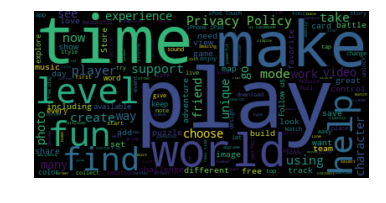

In [337]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.show()

In [338]:
for key in list(wordcloud.words_.keys())[:20]:
    print(str(key)+": {:.2f}".format(wordcloud.words_[key]))
#prints the 1st 20 most frequent words and their (relative) frequency with respect to the 1st one.

play: 1.00
time: 0.98
make: 0.93
world: 0.85
level: 0.74
fun: 0.70
help: 0.68
find: 0.62
Privacy Policy: 0.59
mode: 0.58
create: 0.58
now: 0.58
support: 0.57
player: 0.57
take: 0.56
using: 0.55
experience: 0.55
photo: 0.54
video: 0.54
friend: 0.52


Even after removing the word "game" from the cloud, that theme remains the most predominant aspect of the dataset, which doesn't come exactly as a surprise. However, additional interesting themes appear, such as: time, make (which could have several semantic meanings), world, fun (easily related to the game and play themes), Privacy Policy, create (maybe related to the "make" theme) etc.

Let's try to conduct a deeper analysis on some of the ambiguous words of the above list, in order to better understand their actual meaning.

## Text analysis

In [296]:
import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('averaged_perceptron_tagger')

#downloading the above files is needed for the package functions to work
#uncomment and run the download rows only if first time downloading them

[nltk_data] Downloading package universal_tagset to
[nltk_data]     C:\Users\Federico\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\universal_tagset.zip.


True

In [304]:
from nltk.tokenize import sent_tokenize as stok
from nltk.tokenize import word_tokenize as wtok
from nltk.probability import FreqDist
# from nltk.stem.wordnet import WordNetLemmatizer  
    #eventually not used, replaced with a simpler (albeit dumber) method for lack of time.
from nltk.stem import PorterStemmer

#importing the various modules needed to transform documents into something usable for analysis
#stok is for breaking paragraphs into sentences
#wtok is for breaking paragraphs into single words
#FreqDist returns the count of each word
#Stemmer is a normalization process, it reduces words to their base root. It's dumber than Lemmatizer because
#it doesn't consider the context in which the word appears, but it's also much simpler and quicker to use

In [327]:
sent_token = stok(text)
word_token = wtok(text)

In [311]:
print(sent_token[50:54])
print('\n')
print(word_token[50:54])

['Save money on the products you love:\n• Find everything you need for Spring renovations at the right price.', '• Get the things you love for the right price.', 'New or used, eBay has everything from clothes to electronics to cars.', '• Buy your favorite items from our trusted sellers and save money.']


['Now', 'you', 'can', 'have']


The same huge string that we used before to generate the wordclouds is now split into substrings of single sentences (and another one with single words).

Let's now remove the stopwords and clean it (from punctuation etc...). Since they have been imported above, let's simply use that list.
<br>
<br>

In [308]:
import string
punct = set(string.punctuation)

In [371]:
filtered_word = [w.lower() for w in word_token] #lowercases all words
filtered_word = [w for w in filtered_word if w not in punct] #removes punctuation

print('The aggregated descriptions contain approximately {} words.'.format(len(filtered_word)))

filtered_word = [w for w in filtered_word if w not in stopwords] #removes stopwords
filtered_word = [w for w in filtered_word if len(w) > 2]
#removes mono and two letter words, if any
#and remaining punctuation, if any

ps = PorterStemmer()
filtered_word = [ps.stem(w) for w in filtered_word]

print('The aggregated descriptions, after filtering, contain {} words.'.format(len(filtered_word)))

The aggregated descriptions contain approximately 1767060 words.
The aggregated descriptions, after filtering, contain 991995 words.


In [372]:
fdist = FreqDist(filtered_word)

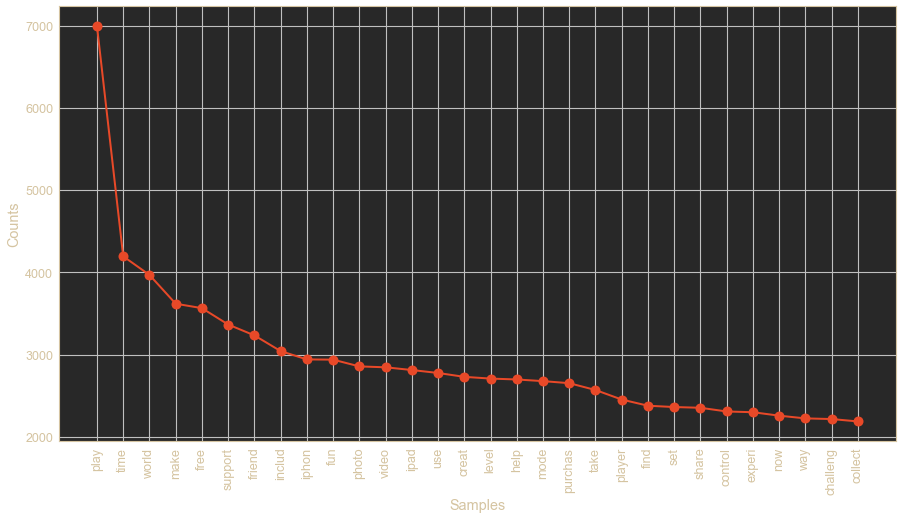

In [373]:
fig = plt.figure(figsize = (15,8))
fdist.plot(30, cumulative=False, color='#E84928', marker='o', markersize=10)

plt.show()

Let's repeat the same operation, this time however instead of tokenizing to the single word, we want to keep the structure of the sentence, in order to have a list of lists, in which every list is (was) a sentence, containing the tokenized words. This way we can, hopefully, find associations between them. 

In [412]:
top_500 = [w[0] for w in fdist.most_common(500)]
top_500 = set(top_500)

In [413]:
filtered_sent = [[w.lower() for w in wtok(sent)] for sent in sent_token] #lowercases all words
filtered_sent = [[w for w in sent if w not in punct] for sent in filtered_sent] #removes punctuation
filtered_sent = [[w for w in sent if w not in stopwords] for sent in filtered_sent] #removes stopwords
filtered_sent = [[w for w in sent if len(w) > 2] for sent in filtered_sent]
#removes mono and two letter words, if any
#and remaining punctuation, if any

filtered_sent = [[w for w in sent if w in top_100] for sent in filtered_sent]
#actually keeps only the top 100 words because I guess the transaction encoder would melt my
#cpu if I kept all the words

filtered_sent = [[ps.stem(w) for w in sent] for sent in filtered_sent]
filtered_sent = [l for l in filtered_sent if l] #removes all the empty lists

### Looking for associations

In [386]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

In [415]:
te = TransactionEncoder()
te_ary = te.fit(filtered_sent).transform(filtered_sent)

In [424]:
df_asso = pd.DataFrame(te_ary, columns = te.columns_)
df_asso = df_asso.drop(['***'], axis = 1)
df_asso.head()

,access,account,build,collect,color,complet,connect,control,custom,day,...,touch,track,unlock,user,video,want,watch,way,work,world
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
frequent_itemsets = apriori(df_asso, min_support=0.000001, use_colnames=True)

In [436]:
frequent_itemsets.head()

Empty DataFrame
Columns: [support, itemsets]
Index: []
